In [1]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List
import seaborn as sns
import re
from typing import Optional
import numpy as np
from collections import Counter
from statistics import mean, median, stdev
from transformers import AutoTokenizer

In [81]:
pwd

'/kaggle/working'

In [2]:
filename = '/kaggle/input/code_comments/data/data/test.json'
#chemin actuel du fichier

# Lire et décoder chaque ligne JSON individuellement
data = []
with open(filename) as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Erreur lors du décodage de la ligne : {e}")

# Afficher les 5 premiers éléments du fichier JSON
for i in data[:5]:
    print(i)

{'code': 'public static String unEscapeString(String str,char escapeChar,char charToEscape){\n  return unEscapeString(str,escapeChar,new char[]{charToEscape});\n}\n', 'nl': 'Unescape <code>charToEscape</code> in the string with the escape char <code>escapeChar</code>'}
{'code': 'public void checkNextPoissonConsistency(double mean){\n  final int sampleSize=1000;\n  final int minExpectedCount=7;\n  long maxObservedValue=0;\n  final double alpha=0.001;\n  UnitTestUtils.Frequency<Long> frequency=new UnitTestUtils.Frequency<Long>();\n  for (int i=0; i < sampleSize; i++) {\n    long value=randomData.nextPoisson(mean);\n    if (value > maxObservedValue) {\n      maxObservedValue=value;\n    }\n    frequency.addValue(value);\n  }\n  PoissonDistribution poissonDistribution=new PoissonDistribution(mean);\n  int lower=1;\n  while (poissonDistribution.cumulativeProbability(lower - 1) * sampleSize < minExpectedCount) {\n    lower++;\n  }\n  int upper=(int)(5 * mean);\n  while ((1 - poissonDistribut

In [3]:
def jsonl_to_dataframe(file_path, columns=['code', 'nl']):
    """Telechargement du JSON lignes file dans pandas DataFrame."""
    df = pd.read_json(file_path, orient='records', lines=True)
    return df[columns]

def get_dfs(path: Path) -> List[pd.DataFrame]:
    """convertir les differents data splits en dataframe pandas"""
    #path est le chemin du folder qui stocke les differents splits de types json il est de type Path
    dfs = []
    for split in ["train.json", "valid.json", "test.json"]:
        file_path = path / split
        if not file_path.exists():
            print(f"File not found: {file_path}")
            dfs.append(pd.DataFrame(columns=['mthd', 'cmt']))  # Créer un DataFrame vide pour ce split
        else:
            df = jsonl_to_dataframe(file_path)
            df = df.rename(columns={'code': 'mthd', 'nl': 'cmt'})
            dfs.append(df)

    return dfs

# Chemin vers les fichiers
path = Path('/kaggle/input/code_comments/data/data')

# Charger les DataFrames
df_trn, df_val, df_tst = get_dfs(path)

#afficher la taille avant l'echantillonage
print(len(df_trn), len(df_val), len(df_tst))

# Échantillonner les DataFrames pour reduire la quantite des donnees originaux dans les dataframes
sample = 0.1
df_trn = df_trn.sample(frac=sample) if not df_trn.empty else df_trn
df_val = df_val.sample(frac=sample) if not df_val.empty else df_val
df_tst = df_tst.sample(frac=sample) if not df_tst.empty else df_tst

# Afficher les tailles des DataFrames échantillonnés
print(len(df_trn), len(df_val), len(df_tst))

470486 58811 58811
47049 5881 5881


In [4]:
df_trn.head()

,mthd,cmt
15390,"boolean inHorizontalScrollbar(int x,int y){\n ...",return true if the x and y position is in the ...
412439,public void test() throws Exception {\n testS...,Tests if the result is valid. Throws an except...
395170,public void determineBounds(){\n double value...,Determine the min and max values for axis and ...
255247,public void testNextIntBounded2(){\n Splittab...,"nextInt(least, bound) returns least <= value <..."
363039,public void testCameraPairwiseScenario23() thr...,Flash: On / Exposure: Max / WB: Auto Scene: Ni...


In [5]:
#data cleaning
# collapse
# From https://stackoverflow.com/a/27084708/5768407
def is_ascii(s):
    '''
    Determines if une chaine donnee contient que les ascii characters

    :param s: the string to check
    :returns: whether or not the given string contains only ascii characters
    '''
    try:
        s.encode(encoding='utf-8').decode('ascii') # encode(encoding='utf-8') : Cette méthode convertit la chaîne s en un format binaire (bytes) en utilisant l'encodage UTF-8
    except UnicodeDecodeError:
        return False
    else:
        return True

df_trn = df_trn[df_trn['mthd'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['mthd'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['mthd'].apply(lambda x: is_ascii(x))]

df_trn = df_trn[df_trn['cmt'].apply(lambda x: is_ascii(x))]
df_val = df_val[df_val['cmt'].apply(lambda x: is_ascii(x))]
df_tst = df_tst[df_tst['cmt'].apply(lambda x: is_ascii(x))]

len(df_trn), len(df_val), len(df_tst)

(47049, 5881, 5881)

In [6]:
# Charger le DataFrame
path = Path('/kaggle/input/code_comments/data/data/train.json')
df = jsonl_to_dataframe(path)

# Identifier les valeurs manquantes
missing_values = df.isna()
print("DataFrame des valeurs manquantes :")
print(missing_values)

#la somme des valeurs manquantes par colonne
missing_values_sum = df.isna().sum()
print("\nNombre de valeurs manquantes par colonne :")
print(missing_values_sum)

# le nombre total de valeurs manquantes
total_missing_values = df.isna().sum().sum()
print("\nNombre total de valeurs manquantes :")
print(total_missing_values)

DataFrame des valeurs manquantes :
         code     nl
0       False  False
1       False  False
2       False  False
3       False  False
4       False  False
...       ...    ...
470481  False  False
470482  False  False
470483  False  False
470484  False  False
470485  False  False

[470486 rows x 2 columns]

Nombre de valeurs manquantes par colonne :
code    0
nl      0
dtype: int64

Nombre total de valeurs manquantes :
0


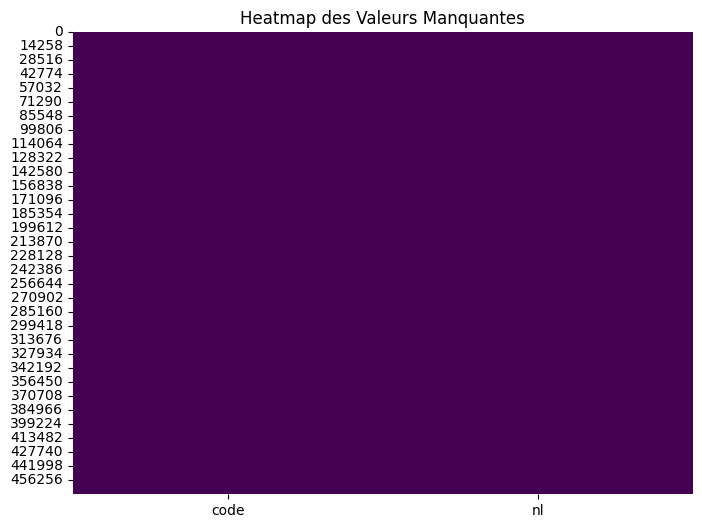

In [7]:
# Afficher un heatmap des valeurs manquantes
plt.figure(figsize=(8, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Heatmap des Valeurs Manquantes")
plt.show()

In [8]:
def has_code(cmt: str) -> bool:
    '''
    Determinine if the given comment contains the HTML <code> tag

    :param cmt: the comment to check whether it contains the HTML <code> tag
    :returns: whether or not the given comment contains the HTML <code> tag
    '''
    if '<code>' in cmt: return True
    else: return False

df_trn = df_trn[~df_trn['cmt'].apply(lambda x: has_code(x))]
df_val = df_val[~df_val['cmt'].apply(lambda x: has_code(x))]
df_tst = df_tst[~df_tst['cmt'].apply(lambda x: has_code(x))]

len(df_trn), len(df_val), len(df_tst)

(44673, 5178, 5630)

In [9]:
def clean_html(cmt: str) -> str:
    '''
    Remove any HTML tags from a given comment

    :param cmt: the comment to remove any HTML tags from
    :returns: the comment with any HTML tags removed
    '''
    result = re.sub(r"<.?span[^>]*>|<.?code[^>]*>|<.?p[^>]*>|<.?hr[^>]*>|<.?h[1-3][^>]*>|<.?a[^>]*>|<.?b[^>]*>|<.?blockquote[^>]*>|<.?del[^>]*>|<.?dd[^>]*>|<.?dl[^>]*>|<.?dt[^>]*>|<.?em[^>]*>|<.?i[^>]*>|<.?img[^>]*>|<.?kbd[^>]*>|<.?li[^>]*>|<.?ol[^>]*>|<.?pre[^>]*>|<.?s[^>]*>|<.?sup[^>]*>|<.?sub[^>]*>|<.?strong[^>]*>|<.?strike[^>]*>|<.?ul[^>]*>|<.?br[^>]*>", "", cmt)
    return result

df_trn.cmt = df_trn.cmt.apply(clean_html)
df_val.cmt = df_val.cmt.apply(clean_html)
df_tst.cmt = df_tst.cmt.apply(clean_html)

In [10]:

df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())

df_trn = df_trn[~(df_trn['cmt'] == '')]
df_val = df_val[~(df_val['cmt'] == '')]
df_tst = df_tst[~(df_tst['cmt'] == '')]

df_trn = df_trn[~df_trn['cmt'].duplicated()]
df_val = df_val[~df_val['cmt'].duplicated()]
df_tst = df_tst[~df_tst['cmt'].duplicated()]

len(df_trn), len(df_val), len(df_tst)

/tmp/ipykernel_34/3057737639.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_trn = df_trn.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_34/3057737639.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_val = df_val.applymap(lambda x: ' '.join(x.split()).lower())
/tmp/ipykernel_34/3057737639.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_tst = df_tst.applymap(lambda x: ' '.join(x.split()).lower())


(37692, 4699, 5063)

In [11]:
# Afficher le résumé statistique
print("Résumé statistique :")
print(df.describe())

Résumé statistique :
                                                     code  \
count                                              470486   
unique                                             389173   
top     private void returnData(Object ret){\n  if (my...   
freq                                                 1284   

                                                   nl  
count                                          470486  
unique                                         300314  
top     <!-- begin-user-doc --> <!-- end-user-doc -->  
freq                                             7604  


In [12]:
# collapse
from tqdm import tqdm
def remove_jdocs(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Remove the JavaDocs leaving only the description of the comment

    :param df: the pandas dataframe to remove the JavaDocs from
    :returns: a new pandas dataframe with the JavaDocs removed
    '''
    methods = []
    comments = []
    for i, row in tqdm(list(df.iterrows())):
        comment = row["cmt"]
        comment = re.sub("([\{\[]).*?([\)\}])", '', comment)


        cleaned = []
        for line in comment.split('\n'):
            if "@" in line: break
            cleaned.append(line)
        comments.append('\n'.join(cleaned))
        methods.append(row["mthd"])
    new_df = pd.DataFrame(zip(methods, comments), columns = ["mthd", "cmt"])

    return new_df

df_trn = remove_jdocs(df_trn);
df_val = remove_jdocs(df_val);
df_tst = remove_jdocs(df_tst);

100%|██████████| 5063/5063 [00:00<00:00, 66530.16it/s]


In [13]:
df_trn.head()

,mthd,cmt
0,"boolean inhorizontalscrollbar(int x,int y){ in...",return true if the x and y position is in the ...
1,public void test() throws exception { testsame...,tests if the result is valid. throws an except...
2,public void determinebounds(){ double value; m...,determine the min and max values for axis and ...
3,public void testnextintbounded2(){ splittabler...,"nextint(least, bound) returns least <= value <..."
4,public void testcamerapairwisescenario23() thr...,flash: on / exposure: max / wb: auto scene: ni...


In [14]:
len(df_trn)

37692

In [15]:
def get_counter(df: pd.DataFrame, tokenizer: AutoTokenizer, col: str) -> Counter:
    '''
    Get the counts for each token in a given pandas dataframe column

    :param df: Un dataframe de type Pandas
    :param tokenizer: Un tokenizer de type Autotokenizer
    dataframe
    :param col: Une chaine de type string indiquant la colonne du dataframe a analyser
    :returns: Le nombre des occurences de chaque token dans la colonne specifiee
       '''
    toks = []
    for i, row in df.iterrows():
      #df.iterrows() retourne un générateur qui produit des paires (index de la ligne, données de la ligne sous forme de série pandas).
        toks.extend(tokenizer.tokenize(row[col]))

    cnt = Counter()
    for tok in toks:
        cnt[tok] += 1
    return cnt

tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base') #Chargement d'un tokenizer pré-entraîné basé sur le modèle microsoft/codebert-base de Hugging Face.
mthd_cnt = get_counter(df_trn, tokenizer, 'mthd')
cmt_cnt = get_counter(df_trn, tokenizer, 'cmt')
mthd_lens = df_trn.mthd.apply(lambda x: len(tokenizer.tokenize(x))).values #Cette méthode (values) extrait les données de la série pandas sous forme de tableau NumPy (array).
cmt_lens = df_trn.cmt.apply(lambda x: len(tokenizer.tokenize(x))).values
max_mthd_len = int(np.quantile(mthd_lens, 0.95)) #Calcul des longueurs maximales à 95% (quantiles) c'est-à-dire la valeur en dessous de laquelle se situent 95% des longueurs de tokens
max_cmt_len = int(np.quantile(cmt_lens, 0.95))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


In [16]:
# collapse
def plot_counts(counts:Counter, top_k: Optional[int] = 30):
    '''
    :param counts: conteur des tokens et de leurs frequences
    :param top_k: le nombre de token a afficher dans le plot
    '''
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

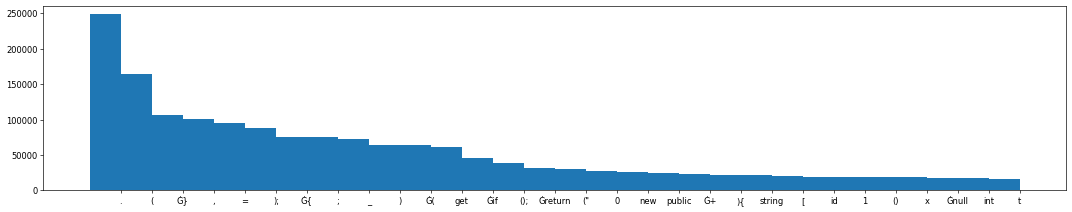

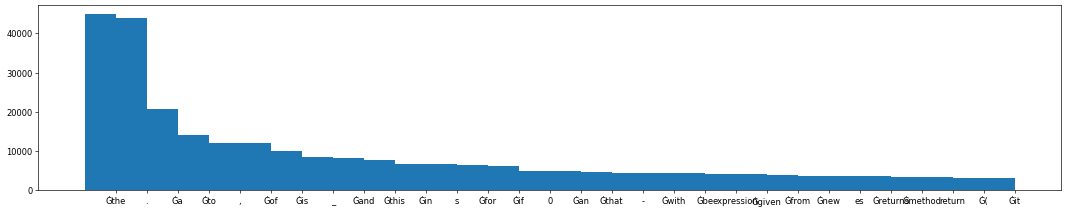

In [17]:
plot_counts(mthd_cnt, top_k = 30)
plot_counts(cmt_cnt, top_k = 30)

In [18]:
# Calcul des statistiques descriptives pour les longueurs des tokens
def descriptive_stats(lengths):
    return {
        'mean': np.mean(lengths), #moyenne
        'median': np.median(lengths), #mediane
        'std_dev': np.std(lengths), #ecart_type
        'min': np.min(lengths),
        'max': np.max(lengths),
        '25th_percentile': np.percentile(lengths, 25), #premier quartile (Q1)
        '75th_percentile': np.percentile(lengths, 75) #troisième quartile (Q3)
    }

mthd_stats = descriptive_stats(mthd_lens)
cmt_stats = descriptive_stats(cmt_lens)

print("Method Lengths Statistics:", mthd_stats)
print("Comment Lengths Statistics:", cmt_stats)


Method Lengths Statistics: {'mean': 129.93391170540167, 'median': 61.0, 'std_dev': 330.56412996461506, 'min': 4, 'max': 33045, '25th_percentile': 29.0, '75th_percentile': 139.0}
Comment Lengths Statistics: {'mean': 20.46550992252998, 'median': 13.0, 'std_dev': 132.68871576907605, 'min': 1, 'max': 14765, '25th_percentile': 8.0, '75th_percentile': 22.0}


In [19]:
print("Top Tokens in Methods:", mthd_cnt.most_common(30))
print("Top Tokens in Comments:", cmt_cnt.most_common(30))

Top Tokens in Methods: [('.', 248701), ('(', 164639), ('Ġ}', 106573), (',', 101447), ('=', 95470), (');', 88325), ('Ġ{', 75119), (';', 74958), ('_', 73004), (')', 64827), ('Ġ(', 64644), ('get', 61609), ('Ġif', 46223), ('();', 38217), ('Ġreturn', 31214), ('("', 30775), ('0', 27420), ('new', 26568), ('public', 24144), ('Ġ+', 23723), ('){', 22266), ('string', 21085), ('[', 20674), ('id', 19039), ('1', 18733), ('()', 18589), ('x', 18541), ('Ġnull', 18121), ('int', 18019), ('t', 16785)]
Top Tokens in Comments: [('Ġthe', 44888), ('.', 43947), ('Ġa', 20712), ('Ġto', 14078), (',', 12000), ('Ġof', 11985), ('Ġis', 9968), ('_', 8427), ('Ġand', 8117), ('Ġthis', 7706), ('Ġin', 6719), ('s', 6679), ('Ġfor', 6464), ('Ġif', 6162), ('0', 4912), ('Ġan', 4862), ('Ġthat', 4631), ('-', 4528), ('Ġwith', 4464), ('Ġbe', 4328), ('expression', 4251), ('Ġgiven', 4062), ('Ġfrom', 4012), ('Ġnew', 3719), ('es', 3528), ('Ġreturns', 3525), ('Ġmethod', 3474), ('return', 3385), ('Ġ(', 3203), ('Ġit', 3160)]


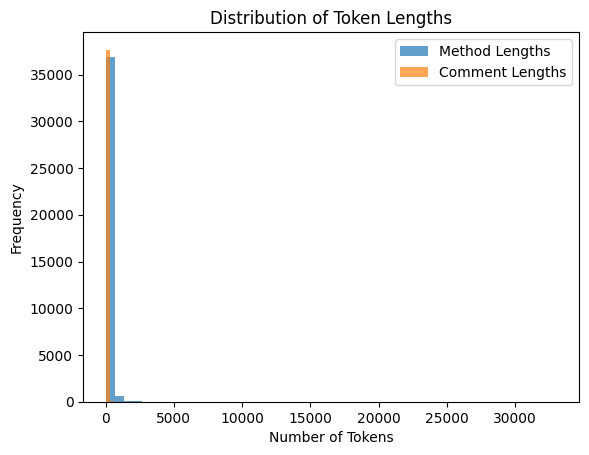

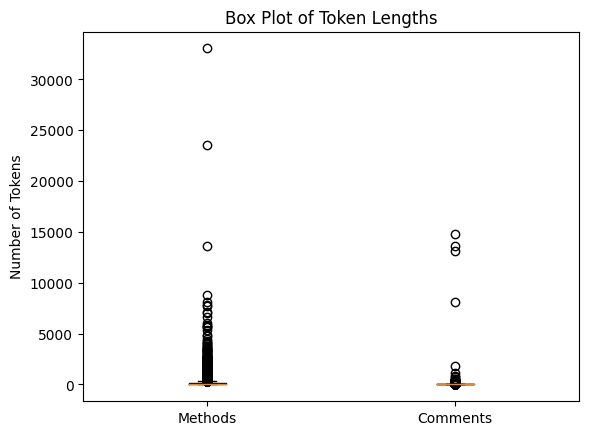

In [20]:
# Histogramme
plt.hist(mthd_lens, bins=50, alpha=0.7, label='Method Lengths')
plt.hist(cmt_lens, bins=50, alpha=0.7, label='Comment Lengths')
plt.legend()
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

# Box Plot
plt.boxplot([mthd_lens, cmt_lens], labels=['Methods', 'Comments'])
plt.ylabel('Number of Tokens')
plt.title('Box Plot of Token Lengths')
plt.show()

## **Model** 

Maintenant nous allons charger le model et le tokenizer pour le Code T5 pre-entraine

In [21]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Chargement du tokenizer spécifique à CodeT5 et le modèle CodeT5
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
model = T5ForConditionalGeneration.from_pretrained('Salesforce/codet5-base')

2024-08-24 17:52:16.607182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 17:52:16.607287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 17:52:16.731466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [22]:
!mkdir java

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


java


In [24]:
df_trn['code_tokens'] = df_trn.mthd.apply(lambda x: x.split()) #Ajouter une nouvelle colonne des tokens au dataframe
df_trn['docstring_tokens'] = df_trn.cmt.apply(lambda x: x.split())
with open('java/train.jsonl','w') as f:
    for _, row in df_trn.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n') #Convertir les row en dictionnaire puis pour l'ecriture dans le fichier json il faut avoir un format chaine de caractere c'est le role de dump

df_val['code_tokens'] = df_val.mthd.apply(lambda x: x.split())
df_val['docstring_tokens'] = df_val.cmt.apply(lambda x: x.split())
with open('java/valid.jsonl','w') as f:
    for _, row in df_val.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

df_tst['code_tokens'] = df_tst.mthd.apply(lambda x: x.split())
df_tst['docstring_tokens'] = df_tst.cmt.apply(lambda x: x.split())
with open('java/test.jsonl','w') as f:
    for _, row in df_tst.iterrows():
        f.write(json.dumps(row.to_dict()) + '\n')

Ce code a pour but la transformation des dataframes en fichier de type json ligne qui est le format convenable pour l'entrainement de notre model

In [25]:
from datasets import load_dataset
# Spécifions notre dataset
data_dir = '.'
lang = 'java'
train_file = f'{data_dir}/{lang}/train.jsonl'
dev_file = f'{data_dir}/{lang}/valid.jsonl'
test_file = f'{data_dir}/{lang}/test.jsonl'

# Chargement des datasets depuis les fichiers JSONL
train_dataset = load_dataset('json', data_files=train_file, split='train')#split='train' signifie que cette dataset sera pour l'entrainnement et meme pour l'evaluation 
eval_dataset = load_dataset('json', data_files=dev_file, split='train')
test_dataset = load_dataset('json', data_files=test_file, split='train')

# Fonction de tokenisation
def tokenize_function(examples):
    inputs = tokenizer(examples['mthd'], padding="max_length", truncation=True, max_length=256) #tokenisée avec un padding jusqu'à une longueur maximale de 256 tokens, de plus les séquences seront soit remplies pour atteindre 256 tokens, soit tronquées si elles sont plus longues.
    labels = tokenizer(examples['cmt'], padding="max_length", truncation=True, max_length=50)
    inputs['labels'] = labels['input_ids']
    return inputs

# Appliquer la tokenisation aux datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/37692 [00:00<?, ? examples/s]

Map:   0%|          | 0/4699 [00:00<?, ? examples/s]

Map:   0%|          | 0/5063 [00:00<?, ? examples/s]

La tokenisation des jeux de donnees jsonl par la fonction **tokenize_function** telle que cette tokenisation sera appliquee avec des batches, qui rend la tokenisation plus efficace, pour préparer un modèle **Seq2Seq** (du CodeT5) à être entraîné.

Maintenant nous allons faire la Configuration des parametres necessaires pour l'entrainement du model 

In [26]:
# Configuration des arguments de l'entraînement
training_args = Seq2SeqTrainingArguments(
    output_dir='./results', #(obligatoire)
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,#(obligatoire)
    per_device_train_batch_size=8,#(obligatoire)
    per_device_eval_batch_size=8,
    num_train_epochs=10,#(obligatoire)
    weight_decay=0.02,
    save_total_limit=3,#conservation seulement des 3 derniers modèles sauvegardés.
    gradient_accumulation_steps=2,
    load_best_model_at_end=True
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [32]:
!pip install wandb

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Ici nous allons commencer l'entainement de notre model en utilisant le model pre entraine seq2seq des transformers de hugging face**

In [27]:
# Configuration du Trainer avec CodeT5
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Entraîner le modèle
trainer.train()

Exception ignored in: <function tqdm.__del__ at 0x78a500aca9e0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):
KeyboardInterrupt: 
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.054800,0.945115
2,0.990600,0.924552
3,0.926600,0.911402
4,0.882000,0.908073
5,0.841300,0.904654
6,0.818900,0.905577
7,0.793600,0.905176
8,0.779500,0.908325
9,0.766300,0.911999
10,0.748400,0.911270


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=11780, training_loss=0.8619965959688196, metrics={'train_runtime': 18861.9875, 'train_samples_per_second': 19.983, 'train_steps_per_second': 0.625, 'total_flos': 1.147642040549376e+17, 'train_loss': 0.8619965959688196, 'epoch': 10.0})

**total_flos=1.147642040549376e+17**

FLOPs (Floating Point Operations), ou le nombre total d'opérations en virgule flottante effectuées pendant l'entraînement.
Ce chiffre est une mesure brute de la complexité de calcul nécessaire pour entraîner le modèle. Un nombre plus élevé indique que l'entraînement était plus intensif en calcul.

**Maintenant nous allons effectuer une evaluation du modele que nous avons entrainer**

In [28]:
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.9046539664268494, 'eval_runtime': 89.7864, 'eval_samples_per_second': 52.335, 'eval_steps_per_second': 3.274, 'epoch': 10.0}


In [130]:
#test_results = trainer.evaluate(eval_dataset=test_dataset)
#print(test_results)

{'eval_loss': 1.2973840236663818, 'eval_runtime': 4.0999, 'eval_samples_per_second': 105.613, 'eval_steps_per_second': 6.829, 'epoch': 10.0}


Maintenant nous allons definir la fonction pour la genaration des commentaire 

In [29]:
import torch

# Définir le périphérique avec le quel on va travailler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Charger le modèle sur le périphérique
model.to(device)

def generate_comment(code):
    # Tokeniser l'entrée et déplacer les tensors sur le périphérique
    inputs = tokenizer(code, return_tensors='pt').to(device)
    #convertir le code en token puis les stoquee dans un tensor par Torch
    
    # Générer des commentaires avec le modèle
    outputs = model.generate(**inputs)
    
    # Décoder le texte généré
    comment = tokenizer.decode(outputs[0], skip_special_tokens=True)#skip_special_tokens=True : Ignore les tokens spéciaux comme les tokens de padding ou de fin de séquence lors du décodage.
    return comment

In [30]:
print(df_tst.columns)


Index(['mthd', 'cmt', 'code_tokens', 'docstring_tokens'], dtype='object')


In [70]:
# Supprimer les colonnes d'index qui peuvent causer des conflits
df_tst = df_tst.drop(columns=['level_0', 'index'], errors='ignore')

# Réinitialiser l'index
df_tst = df_tst.reset_index(drop=True)


**Maintenant affichant les 10 premieres predictions de test**

In [31]:
# Définir la fonction pour vérifier si les commentaires correspondent exactement
def exact_match(predicted, actual):
    return predicted.strip() == actual.strip()

# Nous allons itérer sur les 10 premières lignes du DataFrame pour générer les commentaires
df_tst = df_tst.reset_index(drop=True)
preds = []
actual_comments = df_tst.head(10)['cmt'].tolist()  # stocker les commentaires originaux dans une liste
for idx, row in df_tst.head(10).iterrows():
    generated_comment = generate_comment(row.mthd)  # Générer un commentaire pour chaque ligne
    preds.append(generated_comment.strip())

    # Afficher les résultats pour chaque ligne
    print('Code:', row.mthd)
    print('Original Comment:', row.cmt)
    print('Generated Comment:', generated_comment)
    print('='*40)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Code: @override public void onstarttrackingtouch(seekbar seekbar){ mdragging=true; mhandler.removemessages(show_progress); }
Original Comment: called in devices with touchpad when the user starts to adjust the position of the seekbar's thumb. will be followed by several onprogresschanged notifications.
Generated Comment: called when the seek bar is about to start tracking.
Code: public void clearcommands(){ synchronized (this) { system.out.println("jettisoning " + commandqueue.size() + " commands"); commandqueue.clear(); } }
Original Comment: remove all commands from the queue.
Generated Comment: clears the command queue.
Code: public static probeitemdescriptor continuouslinefillitem(string name,string description,itemvalueformatter formatter,double datafactor,long minvalue,long maxvalue){ return continuousitem(name,description,formatter,datafactor,minvalue,maxvalue,default_line_width,default_color,default_color); }
Original Comment: creates descriptor for a continuous item created by 

## **Evaluation du modele**

**Calculons le Bleu score**

In [32]:
from nltk.translate.bleu_score import sentence_bleu

# Exemple pour calculer le score BLEU
bleu_scores = []

for pred, real in zip(preds, actual_comments):
    # Tokeniser les phrases
    pred_tokens = pred.split()
    real_tokens = real.split()
    score = sentence_bleu([real_tokens], pred_tokens)
    bleu_scores.append(score)

# Calculer la moyenne des scores BLEU
average_bleu = sum(bleu_scores) / len(bleu_scores)
print(f"Average BLEU Score: {average_bleu:.2f}")


Average BLEU Score: 0.38


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


**Interpretation du score:**
Un score de 0.38 est relativement modeste. Cela peut signifier que les commentaires générés capturent une partie des éléments importants des commentaires originaux

In [35]:
model.to('cuda' if torch.cuda.is_available() else 'cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32100, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

Maintenant nous allons calculer les pertes d'informations entre les commentaires generes et ceux originaux

In [36]:
# Fonction de génération de commentaire et calcul de perte
def generate_and_evaluate(row, tokenizer, model):
    # Tokeniser les entrées
    inputs = tokenizer(row.mthd, return_tensors="pt", truncation=True, padding="max_length", max_length=256).to('cuda' if torch.cuda.is_available() else 'cpu')
    labels = tokenizer(row.cmt, return_tensors="pt", truncation=True, padding="max_length", max_length=50).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Générer des commentaires et calculer les sorties
    with torch.no_grad():
        outputs = model(**inputs, labels=labels['input_ids'])
        
    # Calculer les prédictions et la perte
    preds = tokenizer.batch_decode(outputs.logits.argmax(dim=-1), skip_special_tokens=True)
    loss = outputs.loss.item()  # Convertir la perte en un nombre
    return preds[0], loss

generated_comments = []
losses = []

# Itérer sur les 10 premières lignes du DataFrame pour générer les commentaires et calculer les pertes
df_tst = df_tst.reset_index(drop=True)
for _, row in df_tst.head(20).iterrows():
    generated_comment, loss = generate_and_evaluate(row, tokenizer, model)
    generated_comments.append(generated_comment.strip())
    losses.append(loss)

df_tst_filtered = df_tst.head(20).copy()
df_tst_filtered['pred'] = generated_comments
df_tst_filtered['loss'] = losses

# On va trier le DataFrame filtré par la colonne 'loss'
df_sorted_losses = df_tst_filtered.sort_values(by='loss', ascending=True)

# Affichons les résultats 
for _, row in df_sorted_losses.iterrows():
    print('Code:', row['mthd'])
    print('Original Comment:', row['cmt'])
    print('Generated Comment:', row['pred'])
    print('Loss:', row['loss'])
    print('='*40)

Code: public builder(){ }
Original Comment: instantiates a new builder.
Generated Comment: createsiates a new builder.
Loss: 0.0871947854757309
Code: public aemlistitem up(){ buttonup.click(); return this; }
Original Comment: clicks the "up" button.
Generated Comment: clicks the upup" button.
Loss: 0.08768725395202637
Code: public regexfilefilter(string pattern){ if (pattern == null) { throw new illegalargumentexception("pattern is missing"); } this.pattern=pattern.compile(pattern); }
Original Comment: construct a new regular expression filter.
Generated Comment: createss new regex expression filter.
Loss: 0.10429191589355469
Code: public void clearcommands(){ synchronized (this) { system.out.println("jettisoning " + commandqueue.size() + " commands"); commandqueue.clear(); } }
Original Comment: remove all commands from the queue.
Generated Comment: cle all commands from the queue.
Loss: 0.12581554055213928
Code: protected messagesgetchatusersquerywithchatids chatids(integer... value){

On calculera par la suite la moyenne des pertes des 20 premiers exemples

In [37]:
# Calculons la perte totale
total_loss = sum(losses)

print(f"Total Loss: {total_loss:.2f}")


Total Loss: 17.31


**Maintenant nous allons effectuer uen evaluation avec le rouge score**

In [47]:
!pip install py-rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 997.8 kB/s eta 0:00:00a 0:00:01


In [50]:
!pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b76192c47d42d340320b6e37efd166eaf38b03883c0bc79e3b9af2ae712f791d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [51]:
from rouge_score import rouge_scorer

# Créez un objet scorer ROUGE
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Fonction pour générer des commentaires et calculer les scores ROUGE
def generate_and_evaluate_full(df_tst, generate_comment):
    # Initialiser les listes pour les commentaires générés et les commentaires réels
    generated_comments = []
    reference_comments = []

    # Itérer sur toutes les lignes du DataFrame
    for _, row in df_tst.iterrows():
        # Générer un commentaire pour chaque ligne
        generated_comment = generate_comment(row.mthd).strip()
        generated_comments.append(generated_comment)
        
        # Ajouter le commentaire réel
        reference_comments.append(row.cmt)

    # Calculer les scores ROUGE pour chaque paire de textes
    rouge_scores = []
    for gen, ref in zip(generated_comments, reference_comments):
        scores = scorer.score(ref, gen)
        rouge_scores.append(scores)
    
    return generated_comments, reference_comments, rouge_scores

# Appeler la fonction avec votre DataFrame et la fonction de génération de commentaires
generated_comments, reference_comments, rouge_scores = generate_and_evaluate_full(df_tst, generate_comment)

# Afficher quelques résultats
for i in range(5):  # Afficher les premiers résultats pour vérifier
    print(f"Generated Comment {i}: {generated_comments[i]}")
    print(f"Reference Comment {i}: {reference_comments[i]}")
    print(f"ROUGE Scores {i}: {rouge_scores[i]}")
    print("="*40)


Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors


Generated Comment 0: called when the seek bar is about to start tracking.
Reference Comment 0: called in devices with touchpad when the user starts to adjust the position of the seekbar's thumb. will be followed by several onprogresschanged notifications.
ROUGE Scores 0: {'rouge1': Score(precision=0.5, recall=0.2, fmeasure=0.28571428571428575), 'rouge2': Score(precision=0.1111111111111111, recall=0.041666666666666664, fmeasure=0.06060606060606061), 'rougeL': Score(precision=0.4, recall=0.16, fmeasure=0.22857142857142856)}
Generated Comment 1: clears the command queue.
Reference Comment 1: remove all commands from the queue.
ROUGE Scores 1: {'rouge1': Score(precision=0.75, recall=0.5, fmeasure=0.6), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.5, recall=0.3333333333333333, fmeasure=0.4)}
Generated Comment 2: creates a new continuous line fill item.
Reference Comment 2: creates descriptor for a continuous item created by line and filled segments w

**Interpretation des resultats**

Les scores ROUGE montrent généralement que les commentaires générés ont une couverture variable par rapport aux commentaires de référence. Les scores ROUGE-1 (unigrammes) tendent à être plus élevés que les scores ROUGE-2 (bigrammes), ce qui indique que les commentaires générés capturent mieux les mots individuels mais moins les combinaisons de mots ou les séquences longues. Les scores ROUGE-L montrent une couverture modérée des séquences longues, ce qui suggère que les commentaires générés sont partiellement informatifs mais manquent de détails spécifiques par rapport aux commentaires de référence.

## Evaluation avec des exemples humains

In [33]:
# Extrait de code pour le test
code_example = """def add(a, b):
    return a + b"""

# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu (remplacez par un commentaire réel pour comparaison)
real_comment = "This function adds two numbers and returns the result."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")


Code:
def add(a, b):
    return a + b

Generated Comment:
adds two words to the current word specification.

Original Comment:
This function adds two numbers and returns the result.



In [34]:
code_example = """def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True"""
# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu (remplacez par un commentaire réel pour comparaison)
real_comment = "This function checks if a number is prime by testing divisibility from 2 to the square root of the number."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")

Code:
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

Generated Comment:
check if n is prime

Original Comment:
This function checks if a number is prime by testing divisibility from 2 to the square root of the number.



In [43]:
code_example = """def alpha(lst):
    s = 0
    for num in lst:
        s += num
    return s"""
# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu
real_comment = "This function takes a list of numbers and returns the sum of all elements in the list."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")

Code:
def alpha(lst):
    s = 0
    for num in lst:
        s += num
    return s

Generated Comment:
compute the alpha of the given list.

Original Comment:
This function takes a list of numbers and returns the sum of all elements in the list.



In [44]:
code_example = """def fact(n):
    if n == 0 or n == 1:
        return 1
    else:
        return n * fact(n - 1)"""
# Générer un commentaire pour l'extrait de code
generated_comment = generate_comment(code_example)

# Commentaire réel attendu
real_comment = "This function calculates the factorial of a given number using recursion."

print(f"Code:\n{code_example}\n")
print(f"Generated Comment:\n{generated_comment}\n")
print(f"Original Comment:\n{real_comment}\n")


Code:
def fact(n):
    if n == 0 or n == 1:
        return 1
    else:
        return n * fact(n - 1)

Generated Comment:
returns the fact of the given number of terms.

Original Comment:
This function calculates the factorial of a given number using recursion.



## Fin

Apres ces exemples qu'on a utiliser on voit tres bien que ce model utilise e nom de la fonction ainsi que les parametres pour comprendre que fait la fonction 